# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


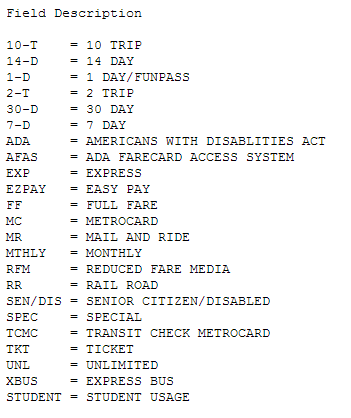

In [415]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 

you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean...
np.nansum...

# HINTS: 

## notes and hints: 

1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collapse the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can 
### sum or average over the ridership types for all station and reduce your data by a factor 23. 
When I ask you "which rideship type ..." you can 
### sum or average over the stations and reduce your data by a factor 600! 
(or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [416]:
mta = np.load("MTA_Fare_py3.npy")

In [417]:
mtaRides = np.load("MTA_Fare.npy")

In [418]:
print("MTA array shape:", mta.shape)
print("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [419]:
DEVELOPING = True
if DEVELOPING:
    mta = mta[::100]
else:
    mta = mta

create a "ride types" list based on the metadata I was given

In [420]:
print("MTA array shape:", mtaRides.shape)
print("MTA array shape summed over all ride types:", np.nansum(mtaRides,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [421]:
mtaRides.flatten().shape

(2677200,)

In [422]:
MTARIDES_nanmean=np.nanmean(mtaRides)
MTARIDES_nansum=np.nansum(mtaRides)
print(MTARIDES_nanmean)
MTARIDES_nansum

2157.8262035


5776932312

In [423]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [424]:
### WEIGHTED RIDES

In [425]:
# for station in range(mta.shape[0]):
#     for rtype in range(mta.shape[1]):
#          for day in range(mta.shape[2]):
#                 print(mta2[station][rtype][day]) = float('nan')
#                 weightedrides = np.average(....weight=...)

In [426]:
#"each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks 
# from 05/19/2010 to 02/19/2014. "

daterange = pd.date_range(start='05/19/2010', periods=194,freq='1W')
#np.log10(weightedrides[i])

In [483]:
daterange

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [215]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

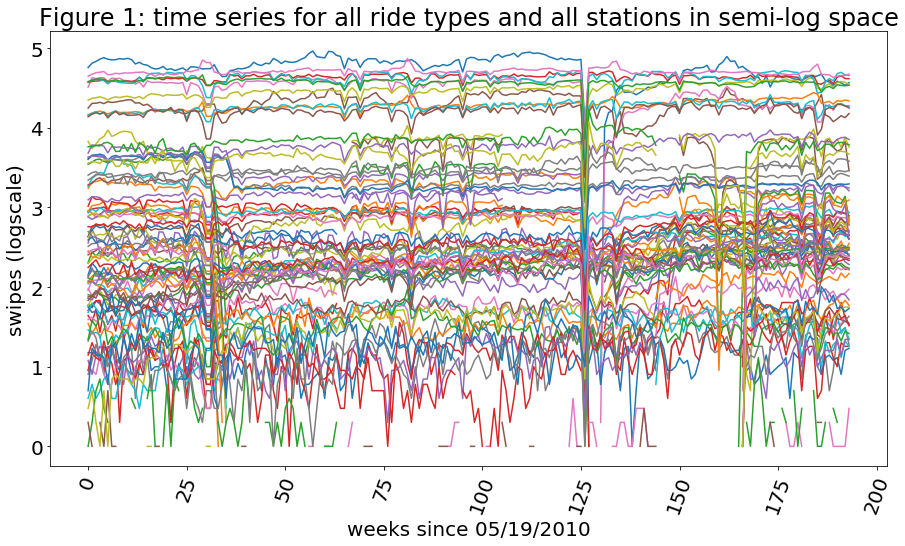

In [216]:
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
ax.set_xlabel('weeks since 05/19/2010')
ax.set_ylabel('swipes (logscale)')
ax.set_title('Figure 1: time series for all ride types and all stations in semi-log space')
plt.xticks(rotation=70)
for station in range(mta.shape[0]):
    for rtype in range(mta.shape[1]):
        #print(mta[station][rtype])
        ax.plot(np.log10(mta[station][rtype]))

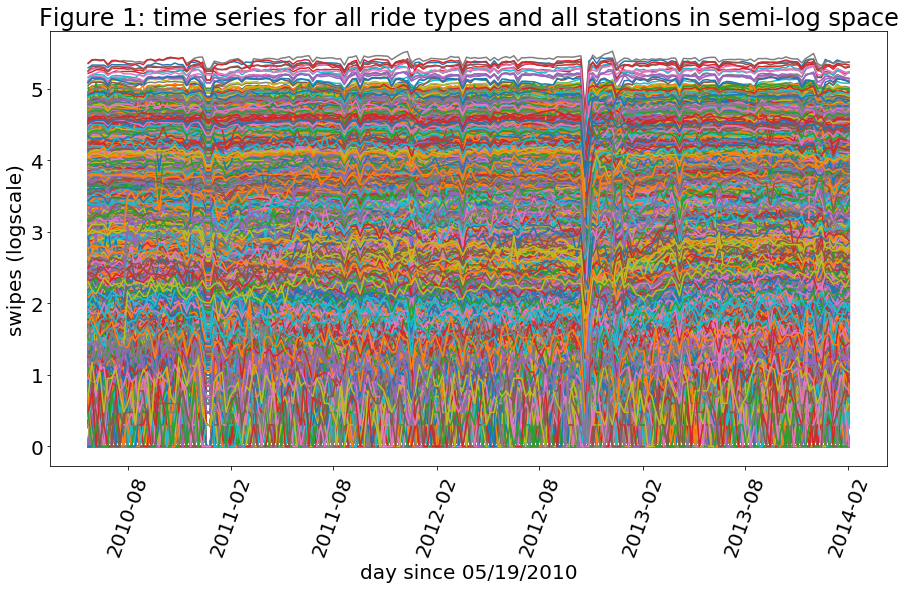

In [52]:
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111)
ax.set_xlabel('day since 05/19/2010')
ax.set_ylabel('swipes (logscale)')
ax.set_title('Figure 1: time series for all ride types and all stations in semi-log space')
plt.xticks(rotation=70)
for station in range(mta.shape[0]):
    for rtype in range(mta.shape[1]):
        #print(mta[station][rtype])
        ax.plot(daterange, np.log10(mta[station][rtype]))

#### Figure 2: Time series for all ride types and all stations in semi-log space

# 1: event detection 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 

In [33]:
## There is an abnormal event on day 125-130 (shwon between '2012-08'and '2013-02') on the last graph above.
## This corresponds to 10/10/2012, which matches when Hurracaine Sandy in New York on Oct 2012.

In [92]:
# for station in range(td_array.shape[0]):
#     for rtype in range(td_array.shape[1]):
#             mta_sum =np.nanmean(mta[station])
#             MTARIDES_nansum=np.nansum(mtaRides)

In [72]:
mta_all=np.nansum(mta,axis=(0,1))

In [77]:
print('std_all:',mta_all.std(),'mean_of_all_values:',mta_all.mean())


std_all: 2984034.34784 mean_of_all_values: 29778001.6082


In [ ]:
## FORMULA TAKEN FROM MAX HUMPHREYS:::::

In [78]:
threshhold = [mta_all.mean()+3*mta_all.std(),mta_all.mean()-3*mta_all.std()]
sandy = np.where(mta_all<threshhold[1])

In [80]:
sandy

(array([126]),)

In [91]:
print("Trains decreased 3-sigma on the week of",daterange[sandy[0][0]-1])

Trains decreased 3-sigma on the week of 2012-10-14 00:00:00


# 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [35]:
## WEIGHTED AVERAGE::::

In [36]:
#pd.rolling_mean() 
#d.rolling_mean(data['realgdp'], 60)

In [38]:
# for station in range(mta.shape[0]):
#     for rtype in range(mta.shape[1]):
#         mta[station][rtype]

# To normalize you data you can do as you suggest and simply calculate:

# x_zi=(x_i−min(x)) / (max(x)−min(x))

In [428]:
def normalize_type_by_station(td_array):
    mta_type_norm=np.nanmean(td_array,axis=0)
    mta_type = np.nanmean(td_array,axis=0)
    mta_type.shape
    for i in range(mta_type.shape[0]):
        #print(np.nanmin(mta_type[i]))
        #break
        mta_type_norm[i]=(mta_type[i]-np.nanmin(mta_type[i]))/(np.nanmax(mta_type[i])-np.nanmin(mta_type[i]))
    return mta_type_norm

In [429]:
def plottd_array(td_array, date_range):
    fig = plt.figure(figsize=(15,8)) 
    ax = fig.add_subplot(111)
    ax.set_xlabel('day since 05/19/2010')
    ax.set_ylabel('swipes (logscale)')
    ax.set_title('Figure 1: time series for all ride types and all stations in semi-log space')
    plt.xticks(rotation=70)
    for station in range(mta.shape[0]):
        for rtype in range(mta.shape[1]):
            #print(mta[station][rtype])
            ax.plot(date_range, np.log10(td_array[station][rtype]))

In [430]:
mta_norm_tbs=normalize_type_by_station(mta)
mta_norm_tbs.shape

(23, 194)

In [431]:
mta_type = np.nanmean(mta,axis=0)
mta_type.shape

(23, 194)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


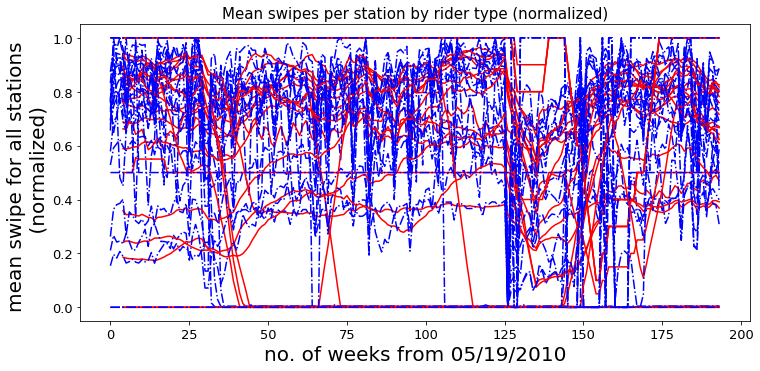

In [221]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(211)
ax.set_xlabel('no. of weeks from 05/19/2010')
ax.set_ylabel('mean swipe for all stations \n (normalized)')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('Mean swipes per station by rider type (normalized)', fontsize=15)
for i in range(mta.shape[1]):
    plt.plot((pd.rolling_mean(mta_norm_tbs[i], window=10, min_periods=5)), label='rolling mean', color='red')
    plt.plot(mta_norm_tbs[i], label='original', linestyle='-.', color='blue')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


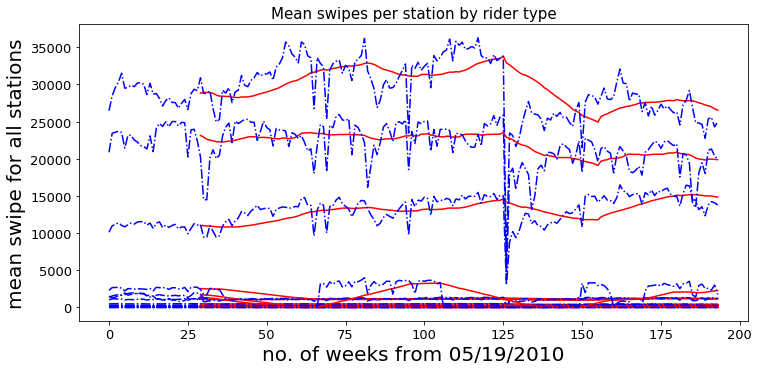

In [222]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(211)
ax.set_xlabel('no. of weeks from 05/19/2010')
ax.set_ylabel('mean swipe for all stations')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('Mean swipes per station by rider type', fontsize=15)
for i in range(mta.shape[1]):
    plt.plot((pd.rolling_mean(mta_type[i], 30)), label='rolling mean', color='red')
    plt.plot(mta_type[i], label='original', linestyle='-.', color='blue')

# TRY ROLLING MEANS =30

In [432]:
ridetp=list(ridetype)

In [465]:
def find_max (td_array,period=30):
    max_ratio = 0.5
    min_ratio = 0.5
    max_ratio2 = 0.5
    min_ratio2 = 0.5
    ratio_beg_end = np.zeros(len(ridetp))
    ratio_end_beg = np.zeros(len(ridetp))

    max_day = np.nan
    max_rtype = np.nan
    max_rtype2 = np.nan
    max_station = np.nan
    min_decrease = np.nan
    min_day = np.nan
    min_rtype = np.nan
    min_rtype2 = np.nan
    min_station = np.nan
    max_array = []
    min_array = []
    max_array2 = []
    min_array2 = []
    chosen_dates = [15,45,150,165]

    #for station in range(td_array.shape[0]):
    for rtype, ridetype in enumerate(ridetp):
        rolling_mean = pd.rolling_mean(td_array[rtype],period)            
        ratio_end_beg[rtype]= \
        (rolling_mean[160]/rolling_mean[30])

        ratio_beg_end[rtype]= \
        (rolling_mean[30]/rolling_mean[160])
        #print('max ratio_beg_end for td_array type',ridetype,"(",rtype,"):", ratio_beg_end[rtype])
        #print('max ratio_end_beg for td_array type',ridetype,"(",rtype,"):", ratio_end_beg[rtype])
        #print(ratio_end_beg[rtype] > max_ratio2)
        #print(type(ratio_beg_end),ratio_beg_end.shape)
        
        if ratio_beg_end[rtype] > max_ratio:                     
           # print("hello3")
            max_ratio = ratio_beg_end[rtype]
            max_rtype = rtype
            #max_station = station
            max_array = rolling_mean
        if ratio_beg_end[rtype] < min_ratio:
            #print("hello4")
            min_ratio = ratio_beg_end[rtype]
            min_rtype = rtype
            #min_station = station
            min_array = rolling_mean
        if ratio_end_beg[rtype] > max_ratio2:                     
         #   print("hello1")
            max_ratio2 = ratio_end_beg[rtype]
            max_rtype2 = rtype
            #max_station = station
            max_array2 = rolling_mean
        if ratio_end_beg[rtype] < min_ratio2:
          #  print("hello2")
            min_ratio2 = ratio_end_beg[rtype]
            min_rtype2 = rtype
            #min_station = station
            min_array2 = rolling_mean

    print('max_ratio',max_ratio,'max_rtype',max_rtype)#,'max_station',max_station)
    print('min_ratio',min_ratio,'min_rtype',min_rtype)#,'min_station',min_station)
    print('max_ratio',max_ratio2,'max_rtype',max_rtype2)#,'max_station',max_station)
    print('min_ratio',min_ratio2,'min_rtype',min_rtype2)#,'min_station',min_station)
    return ratio_beg_end, max_ratio,max_rtype,min_ratio,min_rtype,max_array, min_array,\
    ratio_end_beg, max_ratio2,max_rtype2,min_ratio2,min_rtype2,max_array2, min_array2

In [474]:
#plot findings::::
ratio_beg_end,max_ratio,max_rtype,min_ratio,min_rtype,\
max_array, min_array,\
ratio_end_beg, max_ratio2,max_rtype2, min_ratio2,min_rtype2,\
max_array2, min_array2\
= find_max(mta_type,period=3)
#print('Ratio_beg_end for every type', ratio_beg_end)
#print('Ratio_end_beg for every type', ratio_end_beg)
print("Steepest decrease (max_ratio_beg_end)",np.nanmax(ratio_beg_end))
print("Steepest decrease (min_ratio_beg_end)",np.nanmin(ratio_beg_end))
print("Steepest increase (max_ratio_end_beg (2))",np.nanmax(ratio_end_beg))
print("Steepest increase (min_ratio_end_beg (2))",np.nanmin(ratio_end_beg))

max_ratio 2.00180876027 max_rtype 14
min_ratio -7365.25000001 min_rtype 9
max_ratio 2.96184560781 max_rtype 16
min_ratio -2819.5 min_rtype 12
Steepest decrease (max_ratio_beg_end) 2.00180876027
Steepest decrease (min_ratio_beg_end) -7365.25000001
Steepest increase (max_ratio_end_beg (2)) 2.96184560781
Steepest increase (min_ratio_end_beg (2)) -2819.5


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


In [475]:
## Steepest increase occured at 

<bound method _AxesBase.xaxis_date of <matplotlib.axes._subplots.AxesSubplot object at 0x7fefb9a99ba8>>

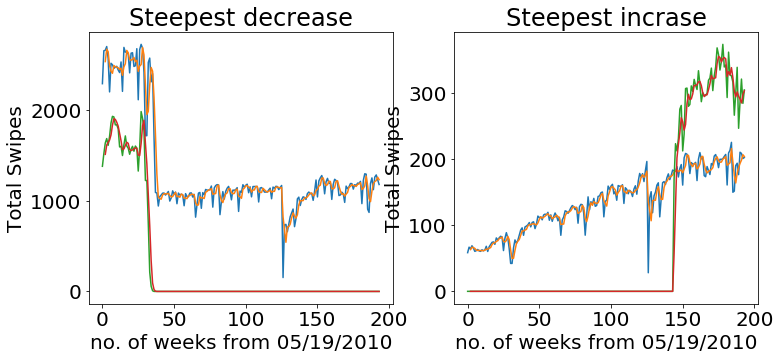

In [478]:

#max_ratio2,max_rtype2,max_station2,min_ratio2,min_rtype2,min_station2,\
#max_array, min_array = find_max(mta,period=100)
fig = plt.figure(figsize  = (12, 5))
ax1 = fig.add_subplot(121)
ax1.plot(mta_type[max_rtype])
ax1.plot(max_array)
ax1.plot(mta_type[min_rtype])
ax1.plot(min_array)
ax1.set_xlabel('no. of weeks from 05/19/2010')
ax1.set_ylabel('Total Swipes')
ax1.set_title('Steepest decrease')

ax2 = fig.add_subplot(122)
ax2.plot(mta_type[max_rtype2])
ax2.plot(max_array2)
ax2.plot(mta_type[min_rtype2])
ax2.plot(min_array2)

ax2.set_xlabel('no. of weeks from 05/19/2010')
ax2.set_ylabel('Total Swipes')
ax2.set_title('Steepest incrase')
ax2.xaxis_date

#### Fig. XXX. Plot shows section with the steepest decrease (left) and steepest increse (right)


In [488]:
mta_type.shape

(23, 194)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


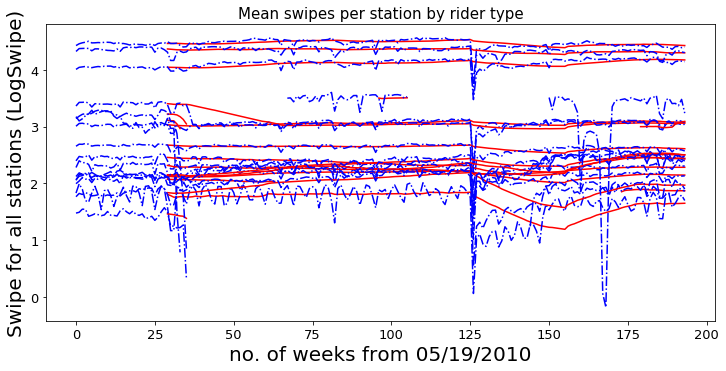

In [492]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(211)
ax.set_xlabel('no. of weeks from 05/19/2010')
ax.set_ylabel('Swipe for all stations (LogSwipe)')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('Mean swipes per station by rider type', fontsize=15)
for i in range(mta.shape[1]):
    plt.plot((pd.rolling_mean(np.log10(mta_type[i]), 30)), label='rolling mean', color='red')
    plt.plot((np.log10(mta_type[i])), label='original', linestyle='-.', color='blue')

#### Fig. XXX. Mean swipes per station by rider type

# Normalized


In [471]:
#plot findings::::
ratio_beg_end,max_ratio,max_rtype,min_ratio,min_rtype,\
max_array, min_array,\
ratio_end_beg, max_ratio2,max_rtype2, min_ratio2,min_rtype2,\
max_array2, min_array2\
= find_max(mta_norm_tbs,period=3)
print("FOR NORMALIZED TIMESERIES:::")
print('Ratio_beg_end for every type', ratio_beg_end)
print('Ratio_end_beg for every type', ratio_end_beg)
print("max_ratio_beg_end",np.nanmax(ratio_beg_end))
print("min_ratio_beg_end",np.nanmin(ratio_beg_end))
print("max_ratio_end_beg (2)",np.nanmax(ratio_end_beg))
print("min_ratio_end_beg (2)",np.nanmin(ratio_end_beg))

max_ratio 14733.5 max_rtype 9
min_ratio 0.0 min_rtype 22
max_ratio inf max_rtype 22
min_ratio 6.78725353784e-05 min_rtype 9
FOR NORMALIZED TIMESERIES:::
Ratio_beg_end for every type [  1.06704300e+00   7.54005251e-01   8.35400763e-01   1.05481674e+00
   1.11680912e+00   6.71829522e-01   9.44178705e-01   2.63000000e+02
   1.00835000e+04   1.47335000e+04   1.57873377e+00   8.38628439e-01
   7.08591674e-04   1.69693252e+00   2.15766580e+00   3.69072647e-01
   2.19830628e-01   1.50000000e+00   3.14750542e-01   1.50000000e+00
   1.50000000e+00   1.50000000e+00   0.00000000e+00]
Ratio_end_beg for every type [  9.37169357e-01   1.32625071e+00   1.19703027e+00   9.48031980e-01
   8.95408163e-01   1.48847284e+00   1.05912154e+00   3.80228137e-03
   9.91719145e-05   6.78725354e-05   6.33419023e-01   1.19242319e+00
   1.41125000e+03   5.89298626e-01   4.63463804e-01   2.70949367e+00
   4.54895666e+00   6.66666667e-01   3.17711923e+00   6.66666667e-01
   6.66666667e-01   6.66666667e-01            

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


<bound method _AxesBase.xaxis_date of <matplotlib.axes._subplots.AxesSubplot object at 0x7fefbb56b080>>

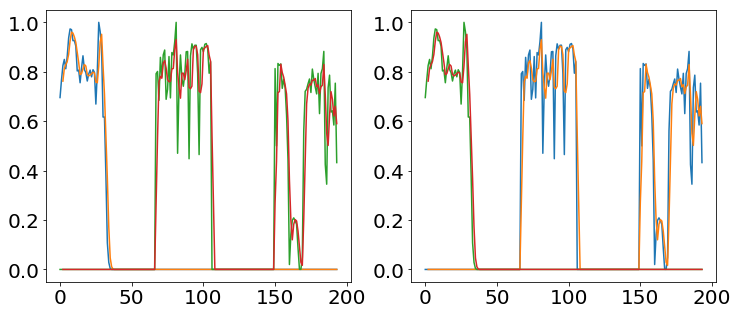

In [472]:
#max_ratio2,max_rtype2,max_station2,min_ratio2,min_rtype2,min_station2,\
#max_array, min_array = find_max(mta,period=100)
fig = plt.figure(figsize  = (12, 5))
ax1 = fig.add_subplot(121)
ax1.plot(mta_norm_tbs[max_rtype])
ax1.plot(max_array)
ax1.plot(mta_norm_tbs[min_rtype])
ax1.plot(min_array)
#ax1.xaxis(
#ax1.xaxis_date

ax2 = fig.add_subplot(122)
ax2.plot(mta_norm_tbs[max_rtype2])
ax2.plot(max_array2)
ax2.plot(mta_norm_tbs[min_rtype2])
ax2.plot(min_array2)
ax2.xaxis_date

13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


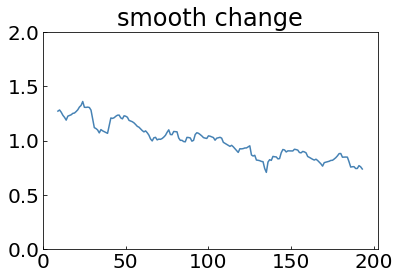

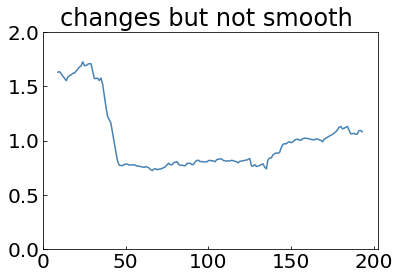

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [537]:
DEVELOPING = FALSE

NameError: name 'FALSE' is not defined

In [534]:
mta.shape

(6, 23, 194)

In [525]:
flattenedmta = mta.reshape(mta.shape[0]*mta.shape[1],mta.shape[2])
flattenedmta.shape

(138, 194)

In [526]:
# sanity check
mta[1][0][0] == flattenedmta[23][0]

True

In [527]:
flatRiderType = np.tile(ridetype, mta.shape[0])
flatRiderType.shape

(6,)

In [529]:
meanstation = np.nanmean(mta, axis=(1,2))
print(meanstation.shape)

(6,)


In [530]:
flatMeanStation = np.repeat(meanstation,mta.shape[1])
flatMeanStation.shape

(138,)

In [531]:
# sanity check
flatMeanStation[0] == flatMeanStation[22]  and flatMeanStation[0] != flatMeanStation[23]

True

In [532]:
stdstation = np.nanmean(mta, axis=(1,2))
print(stdstation.shape)
flatstdStation = np.repeat(stdstation,mta.shape[1])
flatstdStation.shape

(6,)


(138,)

In [533]:
feature1 = np.divide(np.nanmean(flattenedmta,axis=1), flatMeanStation)
feature1.shape

(138,)

In [ ]:
feature2 = np.divide(np.nanstd(flattenedmta,axis=1), flatstdStation)
feature2.shape

In [ ]:
def getRegCoeff(Y):
    if Y.std() > 0:
        X = sm.add_constant(np.array(range(len(Y))))
        mod = sm.OLS(Y,X).fit()
        return mod.params[0],mod.params[1]
    else : 
        return (np.nan,np.nan)

In [ ]:
feature34 = [getRegCoeff(flattenedmta[i]) for i in range(flattenedmta.shape[0])]

In [ ]:
feature3 = [i for i,s in feature34]
feature4 = [s for i,s in feature34]

In [ ]:
Y = flatRiderType

In [ ]:
Xzip = [(f1,f2,f3,f4,y) for (f1,f2,f3,f4,y) in zip(feature1,feature2,feature3,feature4,Y) if \
       not (np.isnan(f1) or np.isnan(f2) or np.isnan(f3) or np.isnan(f4)) ]

In [ ]:
len(Xzip)

In [ ]:
Y = np.array(Xzip)[:,4]
Y.shape

In [ ]:
X = np.array(Xzip)[:,0:4]
X = np.array(X,np.dtype('float'))
X.shape

In [ ]:
tots = []

for i in range(0,len(rtypeidclean)):
    tots.append(mta[stationidclean[i]][rtypeidclean[i]])

In [16]:
label = ...
label.shape

(9317,)

In [17]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [6]:
stationsmeans = ...
stationsmeans.shape

(600,)

In [7]:
stationsstd = ...
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [10]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [11]:
tots = mta.reshape....
tots.shape

(9317, 194)

In [13]:
normed_time_series_mean = ...
normed_time_series_std = ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
normed_time_series_std[:10]

[1.395418982736398,
 0.040502828714548786,
 0.005274169311689245,
 0.015024618528380378,
 0.010724532270930892,
 0.46734881809359824,
 0.7818394435461803,
 0.0013976175988299514,
 0.17261222074600674,
 0.07396098098064302]

In [18]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9317,)

In [19]:
tsmean[:10]

array([5.79828866e+04, 1.80932474e+03, 2.34865979e+02, 7.30041237e+02,
       2.90108247e+02, 1.98267680e+04, 3.02422629e+04, 8.47422680e+00,
       9.67087629e+02, 4.26824742e+02])

In [93]:
tsstdev[:10]


array([18634.01356896,   540.86282986,    70.42970157,   200.63432488,
         143.21224115,  6240.83828981, 10440.45335489,    18.66337324,
        2305.01269034,   987.653128  ])

Text(0, 0.5, 'standardized number of rides')

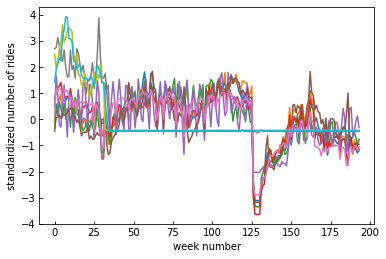

In [25]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

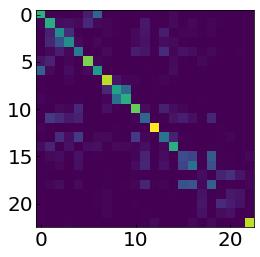

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

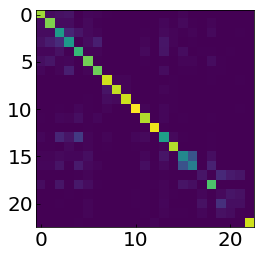

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   